In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.shape

(541909, 8)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Cleaning

In [7]:
# Remove NaN customers
data = df.dropna(subset=['CustomerID'])
data = data.astype({"CustomerID": str})

# Date column as datetime
data['InvoiceTime'] = pd.to_datetime(data['InvoiceDate'])

# Copy of date column as date and month
#data['InvoiceDay'] = data['InvoiceTime'].dt.date
data['InvoiceDay'] = data['InvoiceTime'].astype('datetime64[D]')
data['InvoiceMonth'] = data['InvoiceTime'].astype('datetime64[M]')

# Remove accounting or logistics transactions
acc = ['POSTAGE', 'CARRIAGE', 'Bank Charges','amazon','Next Day Carriage','CRUK Commission', 'AMAZON FEE',
       'PACKING CHARGE', 'DOTCOM POSTAGE']
data = data[~data.Description.isin(acc)]
data = data[~data.Description.str.contains('Dotcomgiftshop Gift Voucher')]

# Remove transactions where UnitPrice < 0.01
data = data[data.UnitPrice >= 0.01]

# Remove all rows with a 1-character code description, as they also don't correspond to real sales
print(data[data.StockCode.str.len() < 2][['StockCode', 'Description']].value_counts())
data = data[data.StockCode.str.len() >= 2]

StockCode  Description
M          Manual         459
D          Discount        77
dtype: int64


In [8]:
data.shape

(404780, 11)

### Canceled orders

In [9]:
# When an order is canceled, a new transaction is recorded with a negative quantity, 
# the same unit price and the new InvoiceNo is prefixed with a 'C'. Both the negative and corresponding 
# positive transactions should be removed from the dataset.
# Note that some negative transactions don't match a positive transaction, they should be removed anyway
cols_merge = ['StockCode', 'UnitPrice', 'CustomerID', 'Country', 'Quantity']
cols_full = cols_merge + ['InvoiceNo', 'Description']

canceled = data[data.InvoiceNo.str.match('^C.*')][cols_full]
canceled['Quantity'] = - canceled['Quantity']

In [10]:
# Match negative w. positive transaction (+ negative transactions with no match to be removed as well)
remove = canceled.merge(data[cols_full], left_on = cols_merge, 
                         right_on= cols_merge, 
                         how='left').sort_values(by=cols_merge)
# Do not over match, in some cases an order was canceled then booked again: remove duplicates
#remove = remove[remove.duplicated(subset=['InvoiceNo_x'], keep='last')] # marks duplicates as true except for last occurence

remove_index = list(remove.InvoiceNo_x.unique()) + list(remove[~remove.InvoiceNo_y.isna()].InvoiceNo_y.unique())
print(len(remove_index))
data = data[~data.InvoiceNo.isin(remove_index)]
data.shape

5555


(329549, 11)

In [11]:
data.describe()

,Quantity,UnitPrice
count,329549.000000,329549.000000
mean,12.700900,2.841493
std,42.255998,4.191078
min,1.000000,0.040000
25%,2.000000,1.250000
50%,6.000000,1.850000
75%,12.000000,3.750000
max,4800.000000,649.500000


## General Statistics

From 2010-12-01 00:00:00 to 2011-12-09 00:00:00

Number of customers: 4236

Number of products: 3819

10 most popular products:
WHITE HANGING HEART T-LIGHT HOLDER    1715
REGENCY CAKESTAND 3 TIER              1388
JUMBO BAG RED RETROSPOT               1354
ASSORTED COLOUR BIRD ORNAMENT         1233
PARTY BUNTING                         1158
LUNCH BAG RED RETROSPOT               1083
SET OF 3 CAKE TINS PANTRY DESIGN       934
LUNCH BAG  BLACK SKULL.                917
PAPER CHAIN KIT 50'S CHRISTMAS         907
PACK OF 72 RETROSPOT CAKE CASES        893
Name: Description, dtype: int64

Average nb of transactions by customer: 78.0

Average total purchase price by customer: 221.0

Most expensive products:
                               Description  UnitPrice
222680      PICNIC BASKET WICKER 60 PIECES      649.5
4989           VINTAGE RED KITCHEN CABINET      295.0
118769        VINTAGE BLUE KITCHEN CABINET      295.0
110843       LOVE SEAT ANTIQUE WHITE METAL      195.0
25168        LOVE S

array([<AxesSubplot:xlabel='InvoiceMonth'>,
       <AxesSubplot:xlabel='InvoiceMonth'>,
       <AxesSubplot:xlabel='InvoiceMonth'>], dtype=object)

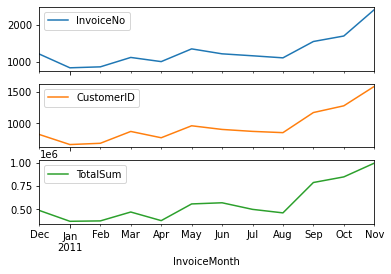

In [12]:
# Data period
print('From', data.InvoiceDay.min(), 'to', data.InvoiceDay.max())

# Number of customers
print('\nNumber of customers:', len(data.CustomerID.unique()))

# Number of products
print('\nNumber of products:', len(data.Description.unique()))

# Most popular products by number of transactions
print('\n10 most popular products:')
print(data.Description.value_counts()[:10])

print('\nAverage nb of transactions by customer:', data.groupby('CustomerID')['InvoiceNo'].count().mean().round())

print('\nAverage total purchase price by customer:', data.groupby('CustomerID')['UnitPrice'].sum().mean().round())

print('\nMost expensive products:')
print(data[['Description','UnitPrice']].drop_duplicates().sort_values(by='UnitPrice', ascending=False)[:10])

# Create TotalSum column
data['TotalSum'] = data['Quantity'] * data['UnitPrice']

# Plot evolution
to_plot = data[data.InvoiceMonth < datetime.datetime.strptime('2011-12-01', '%Y-%m-%d')].\
    groupby('InvoiceMonth').agg({"InvoiceNo": "nunique", 
                                 "CustomerID": "nunique",
                                 "TotalSum": "sum"})

display(to_plot.plot(subplots=True))

## Seasonality

In [13]:
data['day'] = data['InvoiceDay'].dt.day
data['month'] = data['InvoiceDay'].dt.month
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
data['dayofweek'] = data['InvoiceDay'].dt.day_name().astype(cat_type)
data['hour'] = data['InvoiceTime'].dt.hour

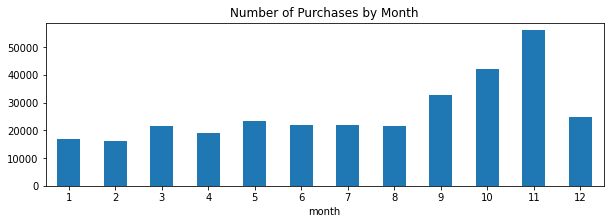

In [14]:
# Plot number of purchases by month (last 12 months of data)
filter_year = data['InvoiceDay'] > (data['InvoiceDay'].max() - datetime.timedelta(days=365))
data[filter_year].groupby('month')['InvoiceNo'].count().plot.bar(rot=0, figsize=(10,3))
plt.title('Number of Purchases by Month')
plt.show()

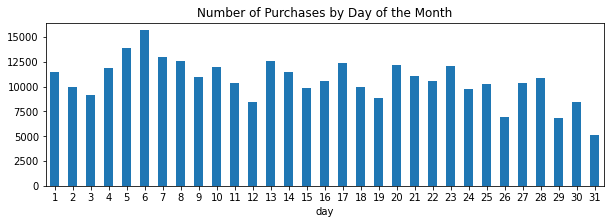

In [15]:
data.groupby('day')['InvoiceNo'].count().plot.bar(rot=0, figsize=(10,3))
plt.title('Number of Purchases by Day of the Month')
plt.show()

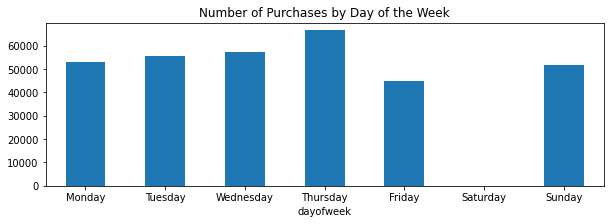

In [16]:
data.groupby('dayofweek')['InvoiceNo'].count().plot.bar(rot=0, figsize=(10,3))
plt.title('Number of Purchases by Day of the Week')
plt.show()

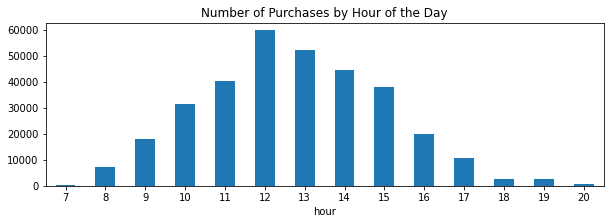

In [17]:
data.groupby('hour')['InvoiceNo'].count().plot.bar(rot=0, figsize=(10,3))
plt.title('Number of Purchases by Hour of the Day')
plt.show()

## Cohorts

In [18]:
# Cohorts of customers based on date of first purchase (~ registration date)
# create a column for date, another for month
data['CohortDay'] = data.groupby('CustomerID')['InvoiceDay'].transform('min')
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [19]:
# Offset of transactions vs cohort in days
data['Offset_CohortDay'] = (data['InvoiceDay'] - data['CohortDay']).dt.days

In [20]:
# Offset of transactions vs cohort in months
def offset_months(x):
    month = x['InvoiceMonth'].month - x['CohortMonth'].month
    year = x['InvoiceMonth'].year - x['CohortMonth'].year
    return year * 12 + month
data['Offset_CohortMonth'] = data.apply(offset_months, axis=1)

In [21]:
# Calculate retention table
retention = data.groupby(['CohortMonth','Offset_CohortMonth'], as_index=False).agg({'CustomerID':'nunique'})
retention = retention.pivot(index='CohortMonth', columns='Offset_CohortMonth', values='CustomerID')
retention

Offset_CohortMonth,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,824.0,272.0,243.0,286.0,269.0,301.0,271.0,258.0,269.0,300.0,293.0,393.0,206.0
2011-01-01,393.0,76.0,101.0,90.0,112.0,109.0,96.0,86.0,123.0,124.0,139.0,47.0,NaN
2011-02-01,366.0,67.0,65.0,100.0,87.0,86.0,85.0,93.0,90.0,108.0,24.0,NaN,NaN
2011-03-01,419.0,53.0,92.0,68.0,87.0,59.0,101.0,91.0,111.0,34.0,NaN,NaN,NaN
2011-04-01,296.0,62.0,65.0,60.0,55.0,69.0,60.0,76.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,296.0,56.0,55.0,54.0,63.0,67.0,80.0,28.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,249.0,44.0,42.0,63.0,57.0,80.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,31.0,33.0,40.0,51.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,173.0,36.0,40.0,42.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# As proportion of first month = first purchase
cohort_sizes = retention.iloc[:, 0]
retention_perc = (100 * retention.divide(cohort_sizes, axis=0)).round(1).fillna('')

In [23]:
retention_perc

Offset_CohortMonth,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,33.0,29.5,34.7,32.6,36.5,32.9,31.3,32.6,36.4,35.6,47.7,25.0
2011-01-01,100.0,19.3,25.7,22.9,28.5,27.7,24.4,21.9,31.3,31.6,35.4,12.0,
2011-02-01,100.0,18.3,17.8,27.3,23.8,23.5,23.2,25.4,24.6,29.5,6.6,,
2011-03-01,100.0,12.6,22.0,16.2,20.8,14.1,24.1,21.7,26.5,8.1,,,
2011-04-01,100.0,20.9,22.0,20.3,18.6,23.3,20.3,25.7,7.4,,,,
2011-05-01,100.0,18.9,18.6,18.2,21.3,22.6,27.0,9.5,,,,,
2011-06-01,100.0,17.7,16.9,25.3,22.9,32.1,10.4,,,,,,
2011-07-01,100.0,16.5,17.6,21.3,27.1,10.1,,,,,,,
2011-08-01,100.0,20.8,23.1,24.3,11.0,,,,,,,,


In [24]:
# Average purchase amount
purchases = data.groupby(['CohortMonth','Offset_CohortMonth'], as_index=False).agg({'TotalSum':'mean'})
purchases = purchases.pivot(index='CohortMonth', columns='Offset_CohortMonth', values='TotalSum')
purchases = purchases.round(1).fillna('')
purchases

Offset_CohortMonth,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,22.2,28.0,29.5,26.8,23.0,29.1,33.5,28.3,25.8,36.8,36.4,24.4,29.6
2011-01-01,17.6,20.2,22.5,19.5,19.4,25.9,27.1,17.6,20.3,22.3,21.2,20.1,
2011-02-01,18.5,19.8,21.3,21.0,18.5,19.1,22.8,21.4,17.1,24.2,25.4,,
2011-03-01,17.4,21.8,27.0,16.7,21.8,20.6,24.1,17.8,15.3,12.3,,,
2011-04-01,16.0,19.5,19.9,18.6,18.7,14.8,14.7,13.9,13.6,,,,
2011-05-01,19.6,17.3,20.2,20.4,19.4,14.7,15.9,14.1,,,,,
2011-06-01,24.0,16.0,18.7,19.8,15.2,15.3,13.4,,,,,,
2011-07-01,15.7,23.6,12.9,14.3,13.3,14.7,,,,,,,
2011-08-01,17.0,12.5,11.1,13.9,14.9,,,,,,,,


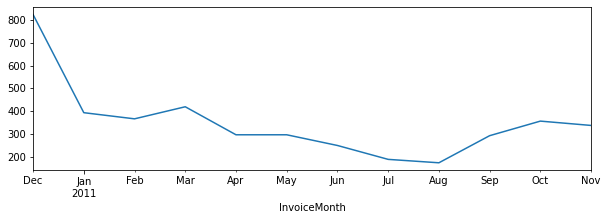

In [25]:
# New vs repeat customers
data[(~data.duplicated(subset='CustomerID'))&(data.InvoiceMonth < '2011/12/01')].groupby('InvoiceMonth').count()['InvoiceNo'].plot(figsize=(10,3))
plt.show()

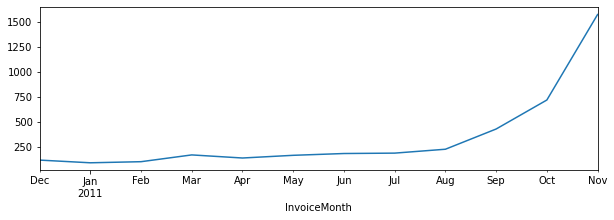

In [26]:
data[(data.duplicated(subset='CustomerID', keep='first')) & (data.InvoiceMonth < '2011/12/01')].drop_duplicates(subset='CustomerID', keep='last').groupby('InvoiceMonth').count()['InvoiceNo'].plot(figsize=(10,3))
plt.show()

## Recency, Frequency & Monetary Value Analysis (RFM)

In [27]:
# Set date used as anchor for evaluation
current = max(data.InvoiceTime) + datetime.timedelta(days=1)

In [28]:
rfm = data.groupby('CustomerID').agg({'InvoiceTime': lambda x: (current - x.max()).days,
                                     'InvoiceNo': 'count',
                                     'TotalSum': 'sum'})
rfm = rfm.rename(columns={'InvoiceTime':'Recency', 'InvoiceNo': 'Frequency', 'TotalSum': 'MonetaryValue'})

In [29]:
# Group into categories
r_quartiles = pd.qcut(rfm['Recency'], 4, labels=range(4,0,-1))
f_quartiles = pd.qcut(rfm['Frequency'], 4, labels=range(1,5))
m_quartiles = pd.qcut(rfm['MonetaryValue'], 4, labels=range(1,5))

rfm = rfm.assign(R = r_quartiles.values)
rfm = rfm.assign(F= f_quartiles.values)
rfm = rfm.assign(M = m_quartiles.values)

In [30]:
rfm['RFM Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

In [31]:
# Apply categories to score
def categorize_rfm_score(x):
    if x > 8:
        return 'High'
    elif x > 4:
        return 'Medium'
    return 'Low'
rfm['RFM Level'] = rfm['RFM Score'].apply(categorize_rfm_score)

rfm.value_counts('RFM Level')

RFM Level
Medium    1877
High      1615
Low        744
dtype: int64

In [32]:
# Calculate mean of RFM scores (+ count for MV)
rfm_mean = rfm.groupby('RFM Score').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(1)
rfm_mean

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM Score                                      
3           260.8       7.6         146.7   372
4           178.7      12.8         228.9   372
5           155.5      19.8         341.9   483
6            99.0      26.2         531.5   474
7            85.5      36.8         689.7   449
8            63.2      51.6         911.7   471
9            48.6      72.7        1329.8   391
10           33.4     108.1        1830.6   424
11           21.8     169.5        3362.3   394
12            7.2     291.0        7827.1   406

## K-Means

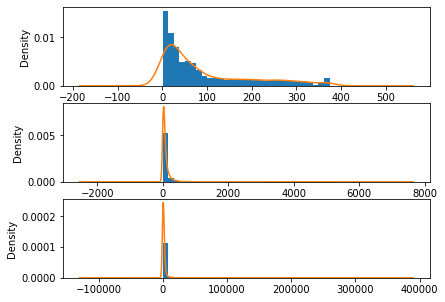

In [33]:
# Ensure that K-means will work:
'''Symmetrical distribution,
similar average values,
same level of variance'''
# Visual Exploration of skeweness in the data
plt.subplot(3, 1, 1)
rfm['Recency'].plot.hist(density=True, bins=30)
rfm['Recency'].plot.kde()

plt.subplot(3, 1, 2)
rfm['Frequency'].plot.hist(density=True, bins=30)
rfm['Frequency'].plot.kde()

plt.subplot(3, 1, 3)
rfm['MonetaryValue'].plot.hist(density=True, bins=30)
rfm['MonetaryValue'].plot.kde()

plt.tight_layout(pad=0)
plt.show()

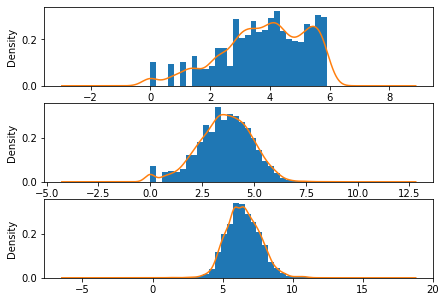

In [34]:
# Log Transform to get rid of data skewness
rfm['Recency_log'] = np.log(rfm['Recency'])
rfm['Frequency_log'] = np.log(rfm['Frequency'])
rfm['MonetaryValue_log'] = np.log(rfm['MonetaryValue'])


plt.subplot(3, 1, 1);
rfm['Recency_log'].plot.hist(density=True, bins=30)
rfm['Recency_log'].plot.kde()

plt.subplot(3, 1, 2);
rfm['Frequency_log'].plot.hist(density=True, bins=30)
rfm['Frequency_log'].plot.kde()

plt.subplot(3, 1, 3);
rfm['MonetaryValue_log'].plot.hist(density=True, bins=30)
rfm['MonetaryValue_log'].plot.kde()

plt.tight_layout(pad=0)
plt.show()

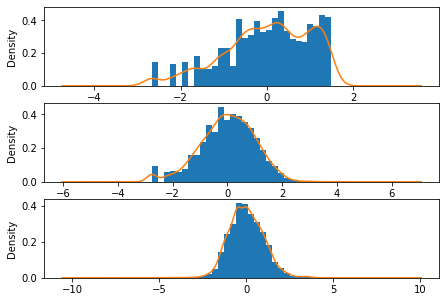

In [35]:
# StandardScaler to get rid of skewness
scaler = StandardScaler()
log_cols = ['Recency_log', 'Frequency_log', 'MonetaryValue_log']
rfm_normalized = scaler.fit_transform(rfm[log_cols])
rfm = rfm.assign(Recency_std = rfm_normalized[:,0])
rfm = rfm.assign(Frequency_std = rfm_normalized[:,1])
rfm = rfm.assign(MonetaryValue_std = rfm_normalized[:,2])
# Alternative - creates a new dataframe: 
# rfm_normalized = pd.DataFrame(data = rfm_normalized, index = rfm.index, columns = log_cols)

plt.subplot(3, 1, 1);
rfm['Recency_std'].plot.hist(density=True, bins=30)
rfm['Recency_std'].plot.kde()

plt.subplot(3, 1, 2);
rfm['Frequency_std'].plot.hist(density=True, bins=30)
rfm['Frequency_std'].plot.kde()

plt.subplot(3, 1, 3);
rfm['MonetaryValue_std'].plot.hist(density=True, bins=30)
rfm['MonetaryValue_std'].plot.kde()

plt.tight_layout(pad=0)
plt.show()

In [36]:
std_col = ['Recency_std', 'Frequency_std', 'MonetaryValue_std']
print(rfm[std_col].mean().round(2), '\n')
print(rfm[std_col].std().round(2))

Recency_std         -0.0
Frequency_std       -0.0
MonetaryValue_std    0.0
dtype: float64 

Recency_std          1.0
Frequency_std        1.0
MonetaryValue_std    1.0
dtype: float64


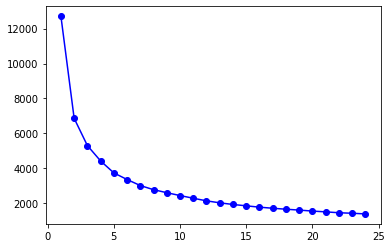

In [37]:
# K-means - find number of clusters
# Elbow method (SSE - sum of squared distance)
sse = {}
for k in range(1, 25):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(rfm[std_col])
    sse[k] = kmeans.inertia_
plt.plot(sse.keys(), sse.values(), color='blue', marker='o')
plt.show();

For n_clusters = 3 The average silhouette_score is : 0.29376949889810205
For n_clusters = 4 The average silhouette_score is : 0.28907643541308525
For n_clusters = 5 The average silhouette_score is : 0.2788975753486341


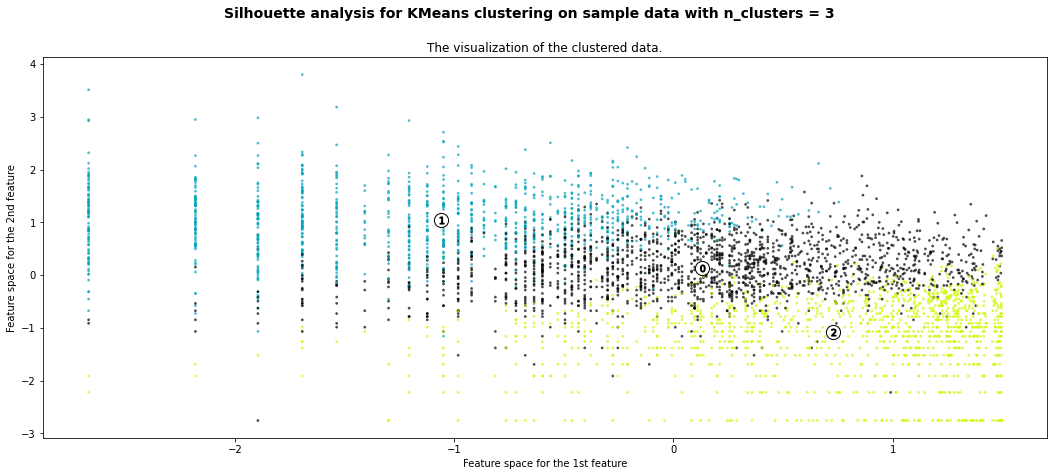

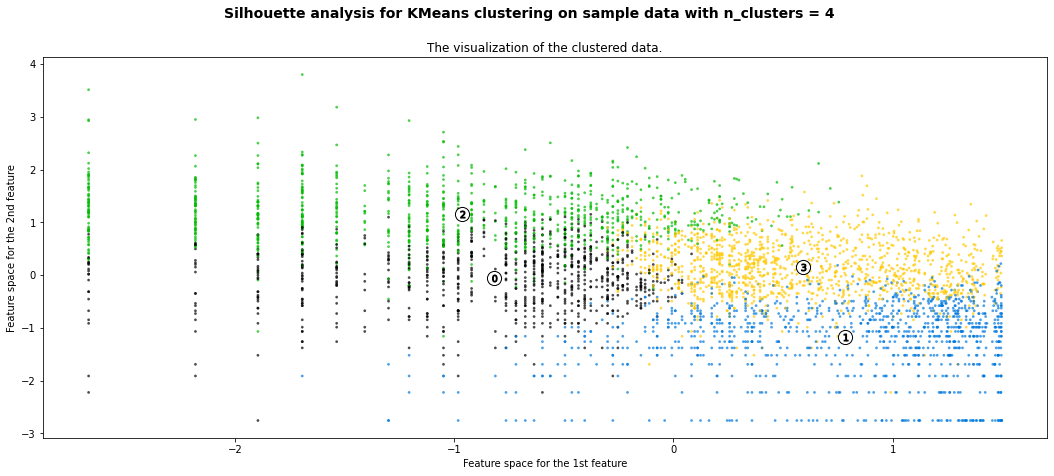

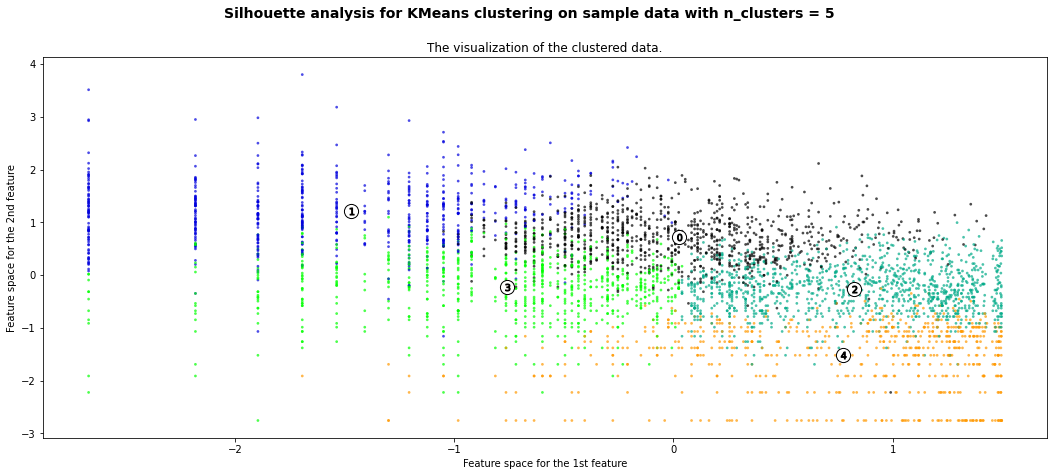

In [38]:
# Silhouette score method
for n_clusters in [3,4, 5]:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm[std_col])

    silhouette_avg = silhouette_score(rfm[std_col], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(rfm[std_col[0]], rfm[std_col[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [39]:
# K means
kmeans = KMeans(n_clusters = 5, random_state = 42)
# Fit k-means cluster algorithm on the normalized data (rfm_normalized)
kmeans.fit(rfm[std_col])

# Add clusters to rfm dataframe
rfm = rfm.assign(Cluster = kmeans.labels_)

rfm.groupby('Cluster').agg({'Recency':'mean', 'Frequency':'mean', 'MonetaryValue': ['mean','count']}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          20.0      34.0         526.0   767
1           8.0     246.0        6598.0   618
2         171.0      30.0         514.0  1161
3          59.0     109.0        1846.0  1025
4         179.0       6.0         187.0   665

In [40]:
# Calculate relative importance of R, F, M for each cluster
cluster_avg = rfm.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1
relative_imp = relative_imp[['Recency','Frequency','MonetaryValue']].round(2)

# Print relative importance scores rounded to 2 decimals
print(relative_imp)

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.79      -0.56          -0.69
1          -0.91       2.17           2.94
2           0.82      -0.61          -0.69
3          -0.37       0.40           0.10
4           0.90      -0.92          -0.89


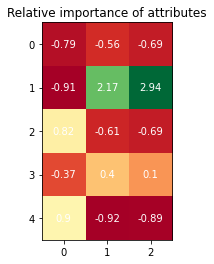

In [41]:
fig, ax = plt.subplots()
ax.set_title('Relative importance of attributes')
ax.imshow(relative_imp, cmap='RdYlGn')

# Loop over data dimensions and create text annotations.
for i in range(relative_imp.shape[0]):
    for j in range(relative_imp.shape[1]):
        text = ax.text(j, i, relative_imp.iloc[i, j],
                       ha="center", va="center", color="w")
        
plt.show()